In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


In [2]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [3]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Read all the images, reshape the images and create labels for them

In [56]:
from tensorflow.contrib.keras import preprocessing

data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

# Set the batch size higher if you can fit in in your GPU memory
batch_size = 500
images = []
labels = []
batch = []


for each in classes:
    print("Starting {} images".format(each))
    class_path = data_dir + each
    files = os.listdir(class_path)
    for ii, file in enumerate(files, 1):
        # Add images to the current batch
        # utils.load_image crops the input images for us, from the center
        img = preprocessing.image.load_img(os.path.join(class_path, file), target_size=(224,224,3))
        img = preprocessing.image.img_to_array(img)
        img = img.reshape((1,) + img.shape) 
        img = img.astype(np.uint8) 
        images.append(img)
        labels.append(each)

        # Running the batch through the network to get the codes
        if ii % batch_size == 0 or ii == len(files):
            print('{} images processed'.format(ii))
print ('Image loading complete.')

Starting daisy images
500 images processed
633 images processed
Starting dandelion images
500 images processed
898 images processed
Starting roses images
500 images processed
641 images processed
Starting sunflowers images
500 images processed
699 images processed
Starting tulips images
500 images processed
799 images processed
Image loading complete.


In [112]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)
print (labels_vecs)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ..., 
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


In [110]:
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels_vecs, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print (y_train)

[[0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 ..., 
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]]


[0 0 1 0 0]
(1, 224, 224, 3)


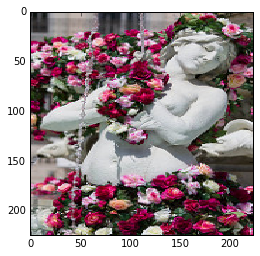

In [59]:
first_image = X_train[1000]
first_label = y_train[1000]
print (first_label)
print (first_image.shape)
plt.imshow(first_image[0])

In [115]:
datagen = preprocessing.image.ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.01,
        height_shift_range=0.01,
        shear_range = 0.01,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

def gen_batch(image, label, count=9):
    batch_data = []
    batch_lables = []
    batch_data.append(image)
    batch_lables.append(label.tolist())
    for X_batch in datagen.flow(x=image):
        gen_image = X_batch[0]
        gen_image = gen_image.reshape((1,) + gen_image.shape)
        gen_image = gen_image.astype(np.uint8) 
        batch_data.append(gen_image)
        batch_lables.append(label.tolist())
        if len(batch_data) > count - 1:
            return batch_data, batch_lables
        
batch_images, batch_labels = gen_batch(first_image, first_label, count=2)

[0 0 1 0 0]


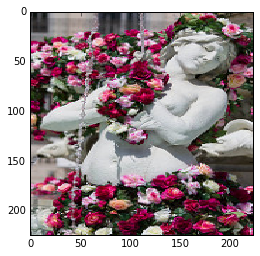

[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 0]


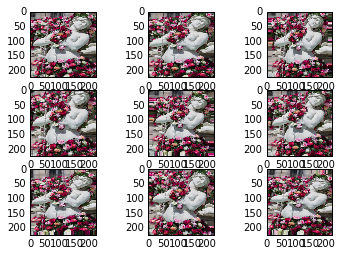

In [116]:
print(first_label)
plt.imshow(first_image[0])
plt.show()


batch_images, batch_labels = gen_batch(first_image, first_label, count=9)
i = 0
print (batch_labels)
for image, label in zip(batch_images, batch_labels):
    plt.subplot(330 + 1 + i)
    print (label)
    plt.imshow(image[0])
    i += 1
    
# show the plot    
plt.show()

In [5]:
from tensorflow.contrib.keras import applications

model = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=None)

57696256/58889256 [============================>.] - ETA: 0s

In [150]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## Make these layers of the model non-trainable since we are going to concentrate only on the classifcation layers

In [152]:
for layer in model.layers:
    layer.trainable = False
    
model.summary()
model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [104]:
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import optimizers
from tensorflow.contrib.keras import applications

def build_flower_classifcation_model(learning_rate=0.001, classes=5):
    # Allocate pre-built model and make non-trainable
    model = models.Sequential()
    vgg = applications.vgg16.VGG16(include_top=False, weights='imagenet', classes=classes, input_shape=(224, 224, 3))
    for layer in vgg.layers:
        trainable = False
        layer.trainable = trainable
        model.add(layer)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(classes, kernel_initializer='zeros', bias_initializer='zeros'))

    model.add(layers.Activation('softmax', name='out'))
    optimizer = optimizers.Adam(lr=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    model.summary()
    return model

model = build_flower_classifcation_model(learning_rate=0.0001, classes=len(labels_vecs[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [120]:
for index in range(len(X_train)):
    single_image = X_train[index]
    single_label = y_train[index]
    batch_images, batch_labels = gen_batch(single_image, single_label, count=9)
    print (batch_labels)
    if index % 10 == 0:
        verbose = True
    else:
        verbose = False
    
    print ('Image: ', index)
    batch_images = np.concatenate(batch_images)
    batch_labels = np.array(batch_labels)
    model.fit(batch_images, batch_labels, validation_data=(X_val, y_val), batch_size=len(batch_images), epochs=1, verbose=verbose)
    
print (model.evaluate(X_test, y_test))

[[0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]]
Image:  0


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 arrays but instead got the following list of 294 arrays: [array([[[[3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
         ..., 
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3]],

        [[3, 3, 3],
         [3, 3, 3],
         [3, 3, 3],
  ...